# COVID-19: Topic Modelling and Search with Top2Vec

[Top2Vec](https://github.com/ddangelov/Top2Vec) is an algorithm for topic modelling. It **automatically** detects topics present in text and generates jointly embedded topic, document and word vectors. Once you train the Top2Vec model you can:
* Get number of detected topics.
* Get topics.
* Search topics by keywords.
* Search documents by topic.
* Find similar words.
* Find similar documents.

This notebook preprocesses the [Kaggle COVID-19 Dataset](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge), it treats each section of every paper as a distinct document. A Top2Vec model is trained on those documents. 

The notebook allows for interacting with the trained model by searching for documents by topic, searching for documents with keywords, searching for topics with keywords, and for finding similar words. These methods all leverage the joint topic, document, word embeddings distances, which represent semantic similarity. 



# Import and Setup 

### 1. Install the [Top2Vec](https://github.com/ddangelov/Top2Vec) library

In [13]:
!pip install top2vec

### 2. Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import json
import os
import ipywidgets as widgets
from IPython.display import clear_output, display
from top2vec import Top2Vec

## Pre-process Data

### 1. Import Metadata

In [3]:
metadata_df = pd.read_csv("../input/CORD-19-research-challenge/metadata.csv")
metadata_df.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_full_text,full_text_file,url
0,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/001727
1,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/003889
2,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/006866
3,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/007476
4,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,biorxiv_medrxiv,https://doi.org/10.1101/010389


### 2. Pre-process Papers

A document will be created for each section of every paper. This document will contain the id, title, abstract, and setion of the paper. It will also contain the text of that section.

In [4]:
dataset_dir = "../input/CORD-19-research-challenge/"
comm_dir = dataset_dir+"comm_use_subset/comm_use_subset/"
noncomm_dir = dataset_dir+"noncomm_use_subset/noncomm_use_subset/"
custom_dir = dataset_dir+"custom_license/custom_license/"
biorxiv_dir = dataset_dir+"biorxiv_medrxiv/biorxiv_medrxiv/"
directories_to_process = [comm_dir,noncomm_dir, custom_dir, biorxiv_dir]

papers_with_text = list(metadata_df[metadata_df.has_full_text==True].sha)

paper_ids = []
titles = []
abstracts = []
sections = []
body_texts = []

for directory in directories_to_process:
    
    filenames = os.listdir(directory)

    for filename in filenames:

      file = json.load(open(directory+filename, 'rb'))

      #check if file contains text
      if file["paper_id"] in papers_with_text:

        section = []
        text = []

        for bod in file["body_text"]:
          section.append(bod["section"])
          text.append(bod["text"])

        res_df = pd.DataFrame({"section":section, "text":text}).groupby("section")["text"].apply(' '.join).reset_index()

        for index, row in res_df.iterrows():

          # metadata
          paper_ids.append(file["paper_id"])

          if(len(file["abstract"])):
            abstracts.append(file["abstract"][0]["text"])
          else:
            abstracts.append("")

          titles.append(file["metadata"]["title"])

          # add section and text
          sections.append(row.section)
          body_texts.append(row.text)
            
papers_df = pd.DataFrame({"id":paper_ids, "title": titles, "abstract": abstracts, "section": sections, "text": body_texts})

In [5]:
papers_df.head()

,id,title,abstract,section,text
0,71ff6abe3023a4c48fd6e6c54265bce395b88397,Rhinovirus-associated pulmonary exacerbations ...,,Collection of clinical information and specimens,Clinical data and PFT were recorded at each vi...
1,71ff6abe3023a4c48fd6e6c54265bce395b88397,Rhinovirus-associated pulmonary exacerbations ...,,Discussion,The results of this pilot study show that rhin...
2,71ff6abe3023a4c48fd6e6c54265bce395b88397,Rhinovirus-associated pulmonary exacerbations ...,,Exploratory data analysis,The only risk factor significantly associated ...
3,71ff6abe3023a4c48fd6e6c54265bce395b88397,Rhinovirus-associated pulmonary exacerbations ...,,Introduction,Despite conventional management with antibioti...
4,71ff6abe3023a4c48fd6e6c54265bce395b88397,Rhinovirus-associated pulmonary exacerbations ...,,Other PFT parameters,Non-responder patients failed significantly to...


### 3. Filter Short Sections

In [6]:
papers_df["token_counts"] = papers_df["text"].str.split().map(len)
papers_df = papers_df[papers_df.token_counts>200].reset_index(drop=True)
papers_df.drop('token_counts', axis=1, inplace=True)
papers_df.head()

,id,title,abstract,section,text
0,71ff6abe3023a4c48fd6e6c54265bce395b88397,Rhinovirus-associated pulmonary exacerbations ...,,Discussion,The results of this pilot study show that rhin...
1,71ff6abe3023a4c48fd6e6c54265bce395b88397,Rhinovirus-associated pulmonary exacerbations ...,,Introduction,Despite conventional management with antibioti...
2,71ff6abe3023a4c48fd6e6c54265bce395b88397,Rhinovirus-associated pulmonary exacerbations ...,,Study population,"In the present study, 34 patients were include..."
3,eb1cc7c78d58eee6f6f81092426a9a5c9aab696c,,,CASE REPORT,"A male, 39-year-old Caucasian, diagnosed with ..."
4,eb1cc7c78d58eee6f6f81092426a9a5c9aab696c,,,DISCUSSION,With recent advances in CF treatment and inten...


## Train Top2Vec Model
Parameters:
  * ``documents``: Input corpus, should be a list of strings.
  
  * ``speed``: This parameter will determine how fast the model takes to train. 
    The 'fast-learn' option is the fastest and will generate the lowest quality
    vectors. The 'learn' option will learn better quality vectors but take a longer
    time to train. The 'deep-learn' option will learn the best quality vectors but 
    will take significant time to train.  
    
  * ``workers``: The amount of worker threads to be used in training the model. Larger
    amount will lead to faster training.
    
See [Documentation](https://top2vec.readthedocs.io/en/latest/README.html).

In [ ]:
top2vec = Top2Vec(documents=papers_df.text, speed="learn", workers=4)

## (Recommended) Load Pre-trained Model and Pre-processed Data :)

The Top2Vec model was trained with the 'deep-learn' speed parameter and took very long to train. It will give much better results than training with 'fast-learn' or 'learn'.

Data is available on my [kaggle](https://www.kaggle.com/dangelov/covid19top2vec).

### 1. Load pre-trained Top2Vec model 

In [7]:
top2vec = Top2Vec.load("../input/covid19top2vec/covid19_deep_learn_top2vec")

### 2. Load pre-processed papers

In [8]:
papers_df = pd.read_feather("../input/covid19top2vec/covid19_papers_processed.feather")

# Use Top2Vec for Semantic Search

### "What is known about transmission, incubation, and environmental stability?"

## 1. Search Topics 

Discover topics relevant to **COVID-19** and **infection**.

Label(value='Enter keywords seperated by space: ')

Text(value='covid infect')

Label(value='Enter negative keywords seperated by space: ')

Text(value='')

Label(value='Choose number of topics: ')

Text(value='10')

Button(description='show topics', style=ButtonStyle())

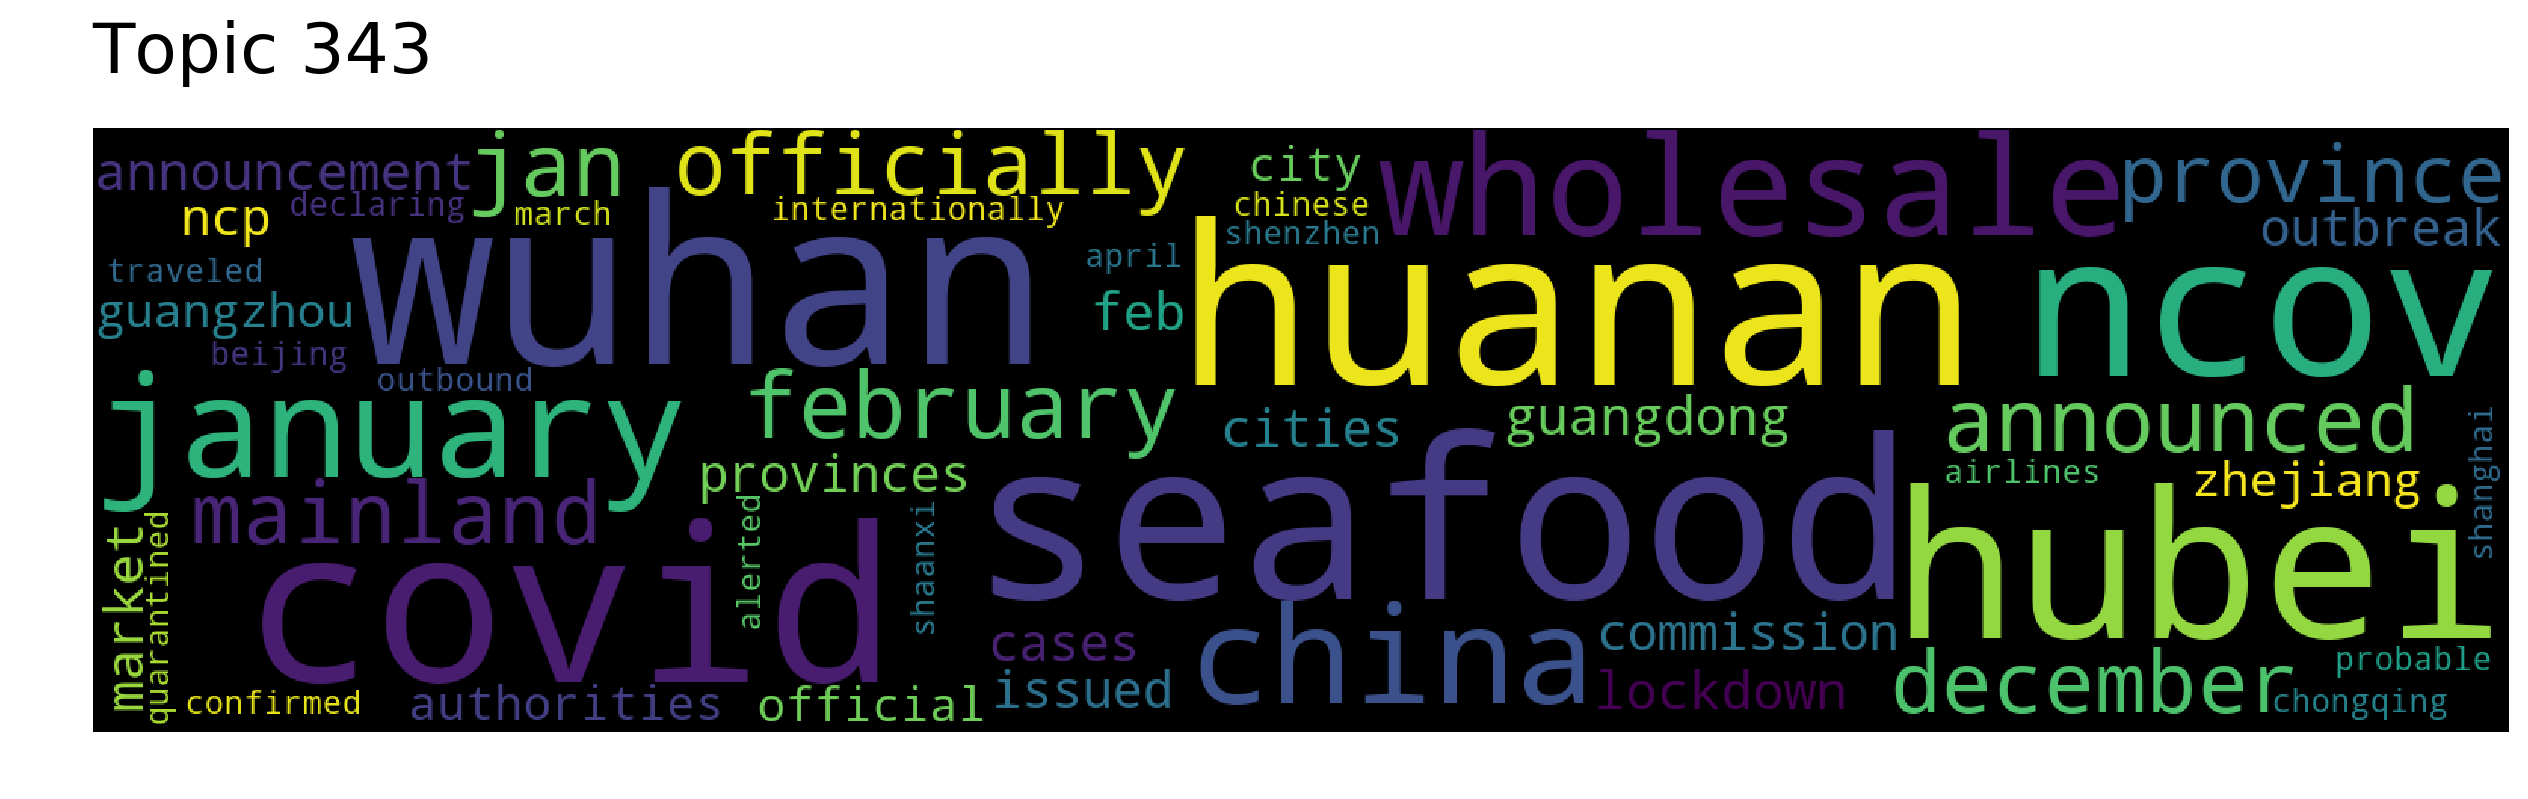

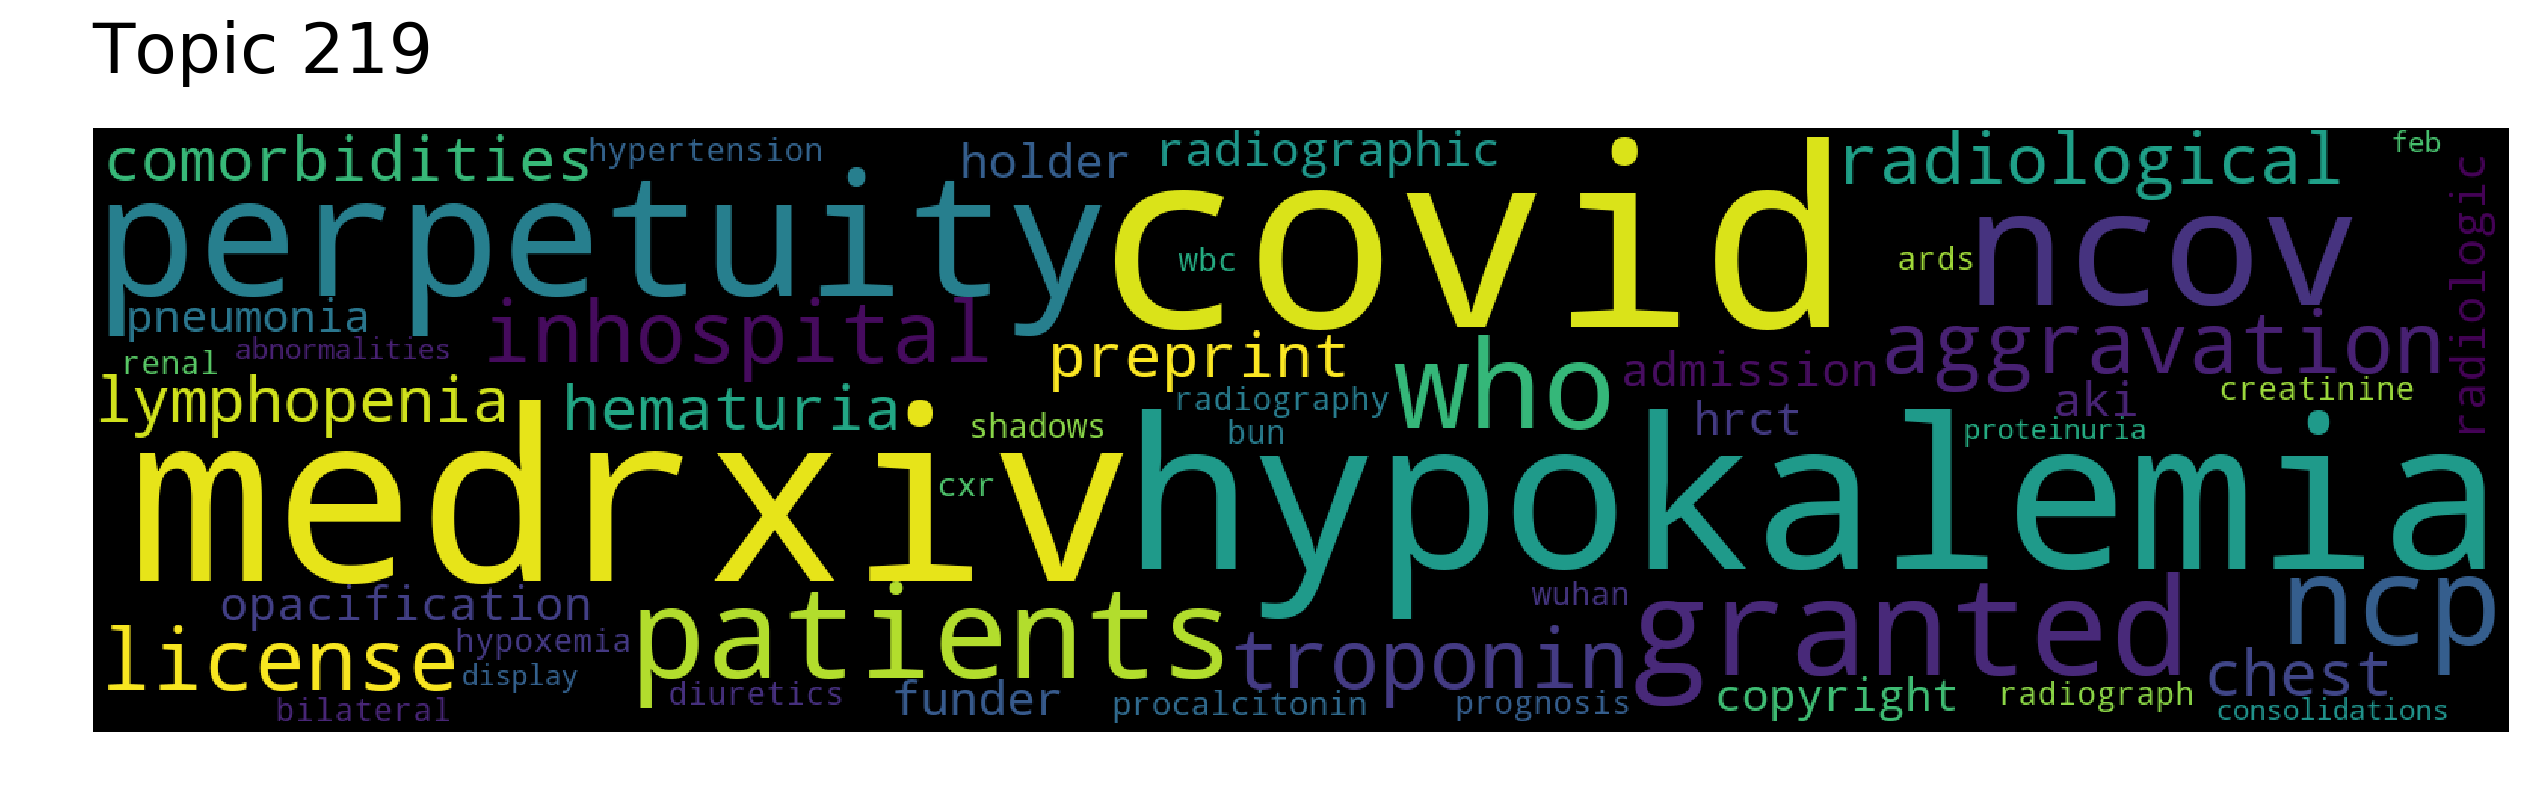

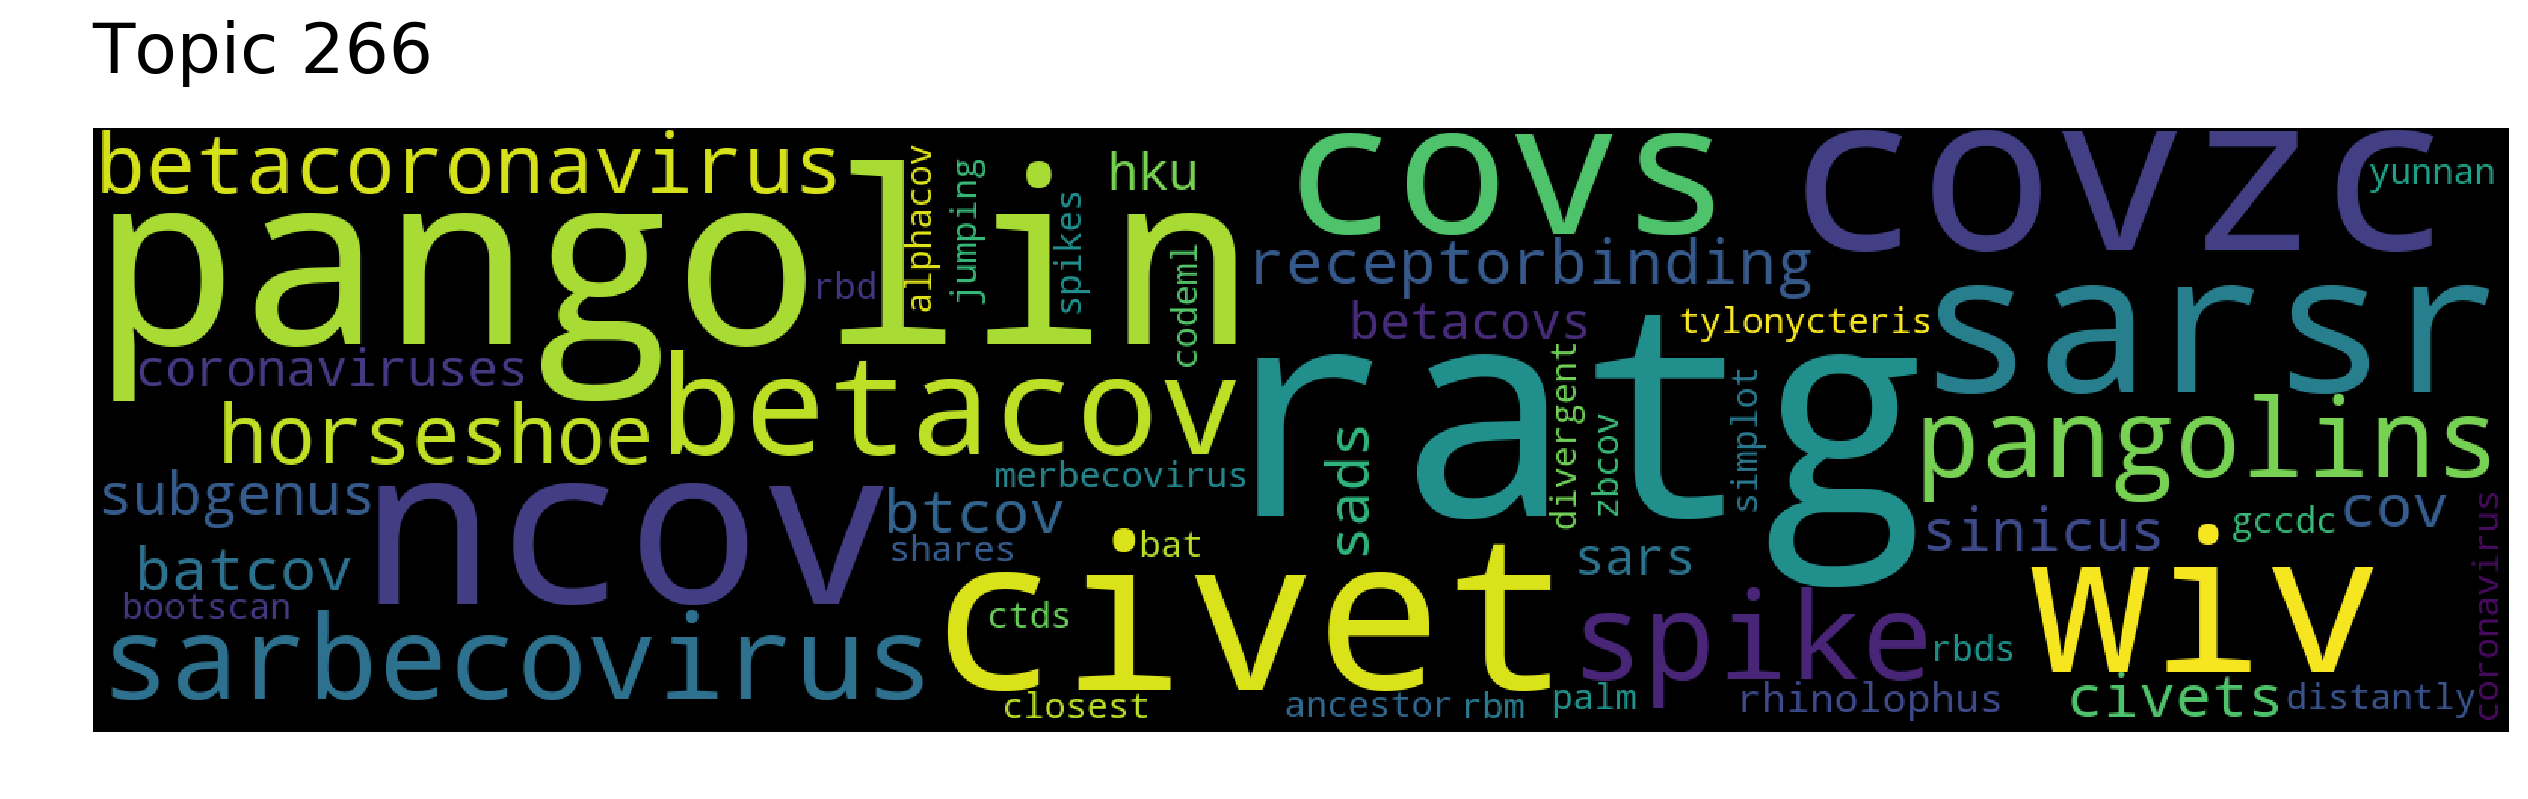

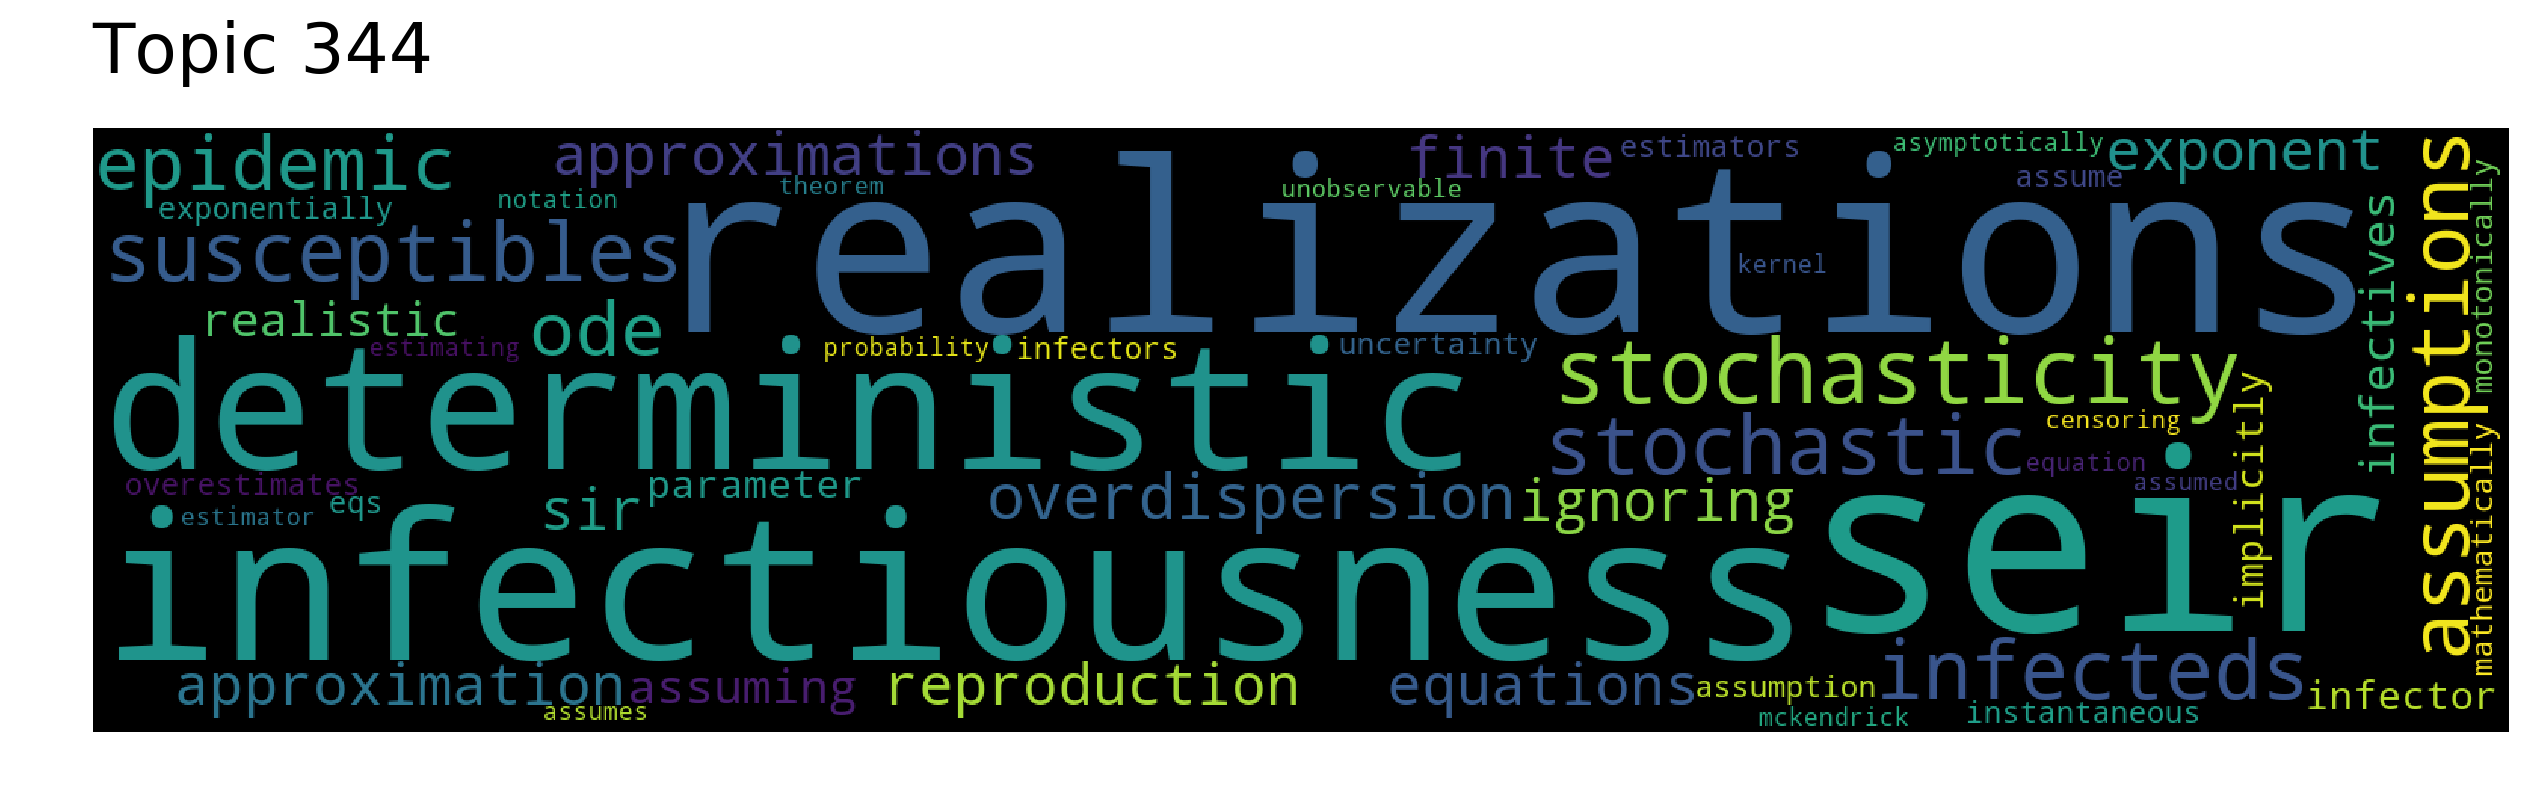

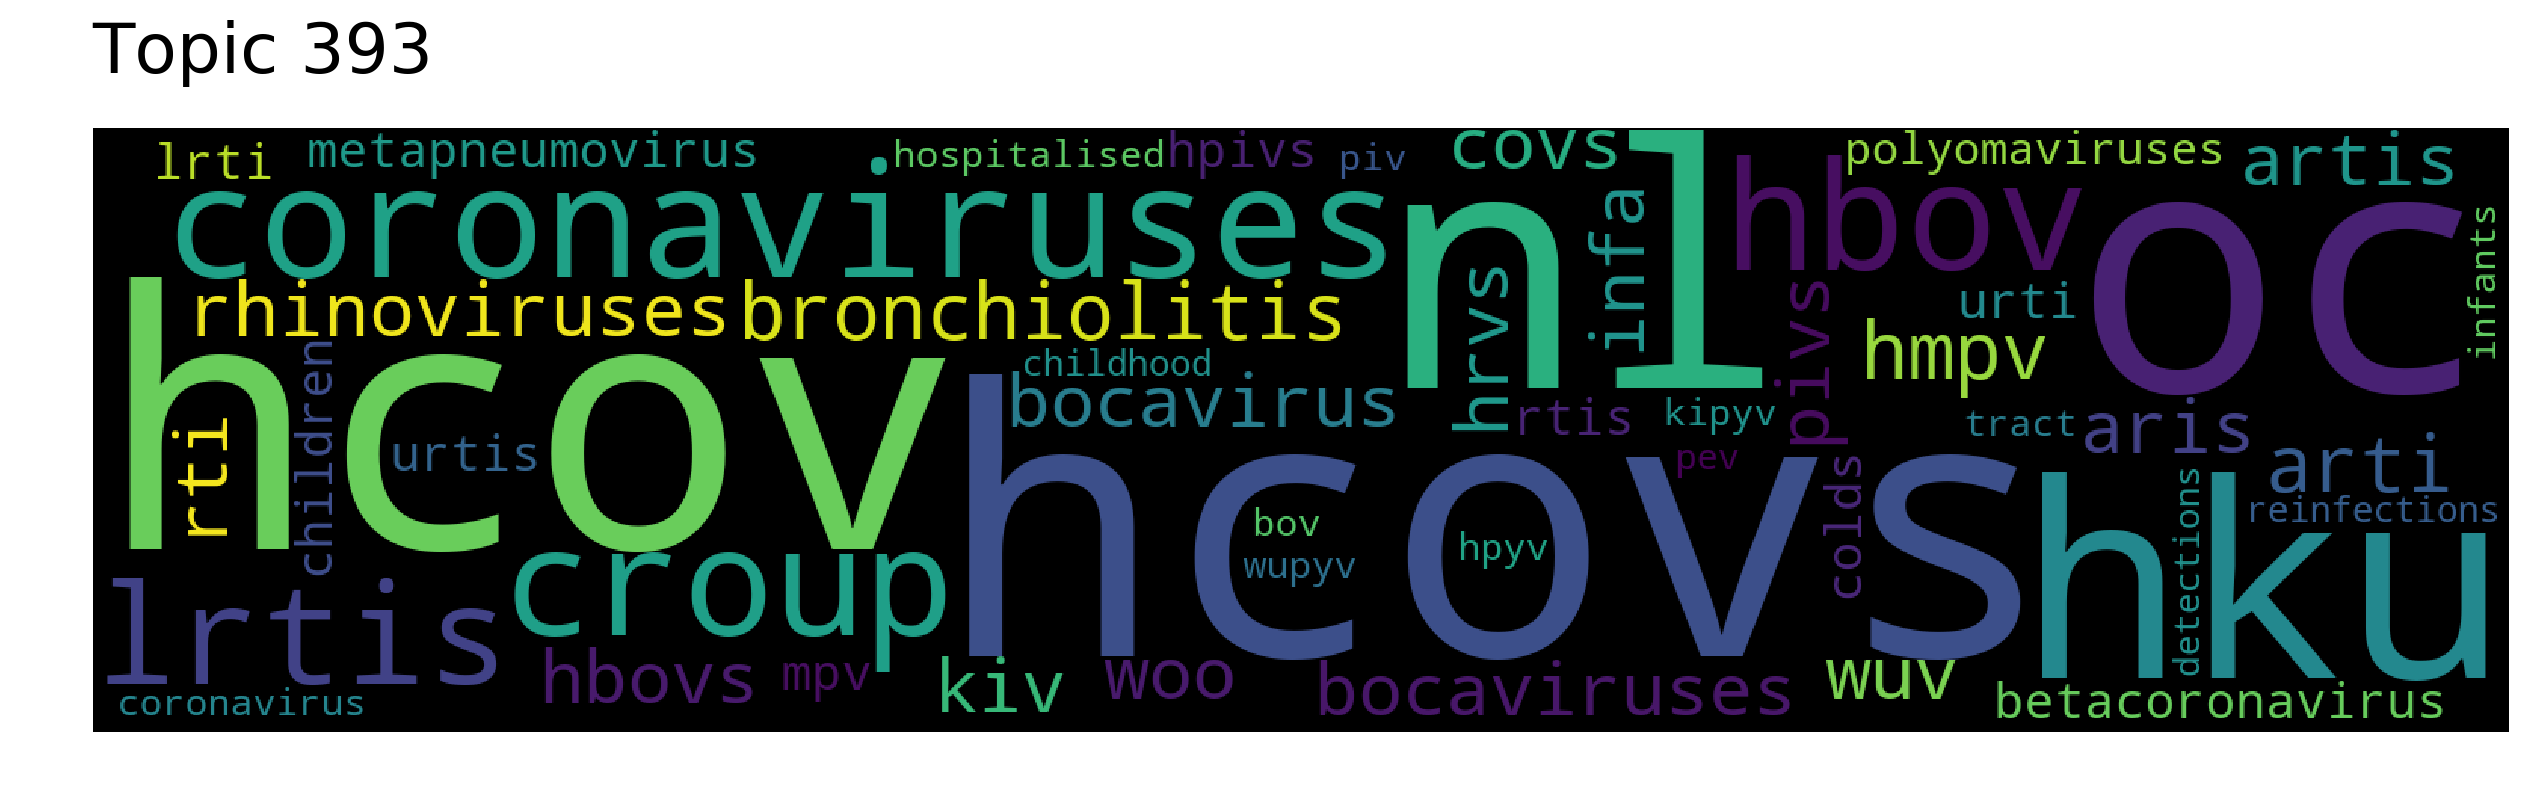

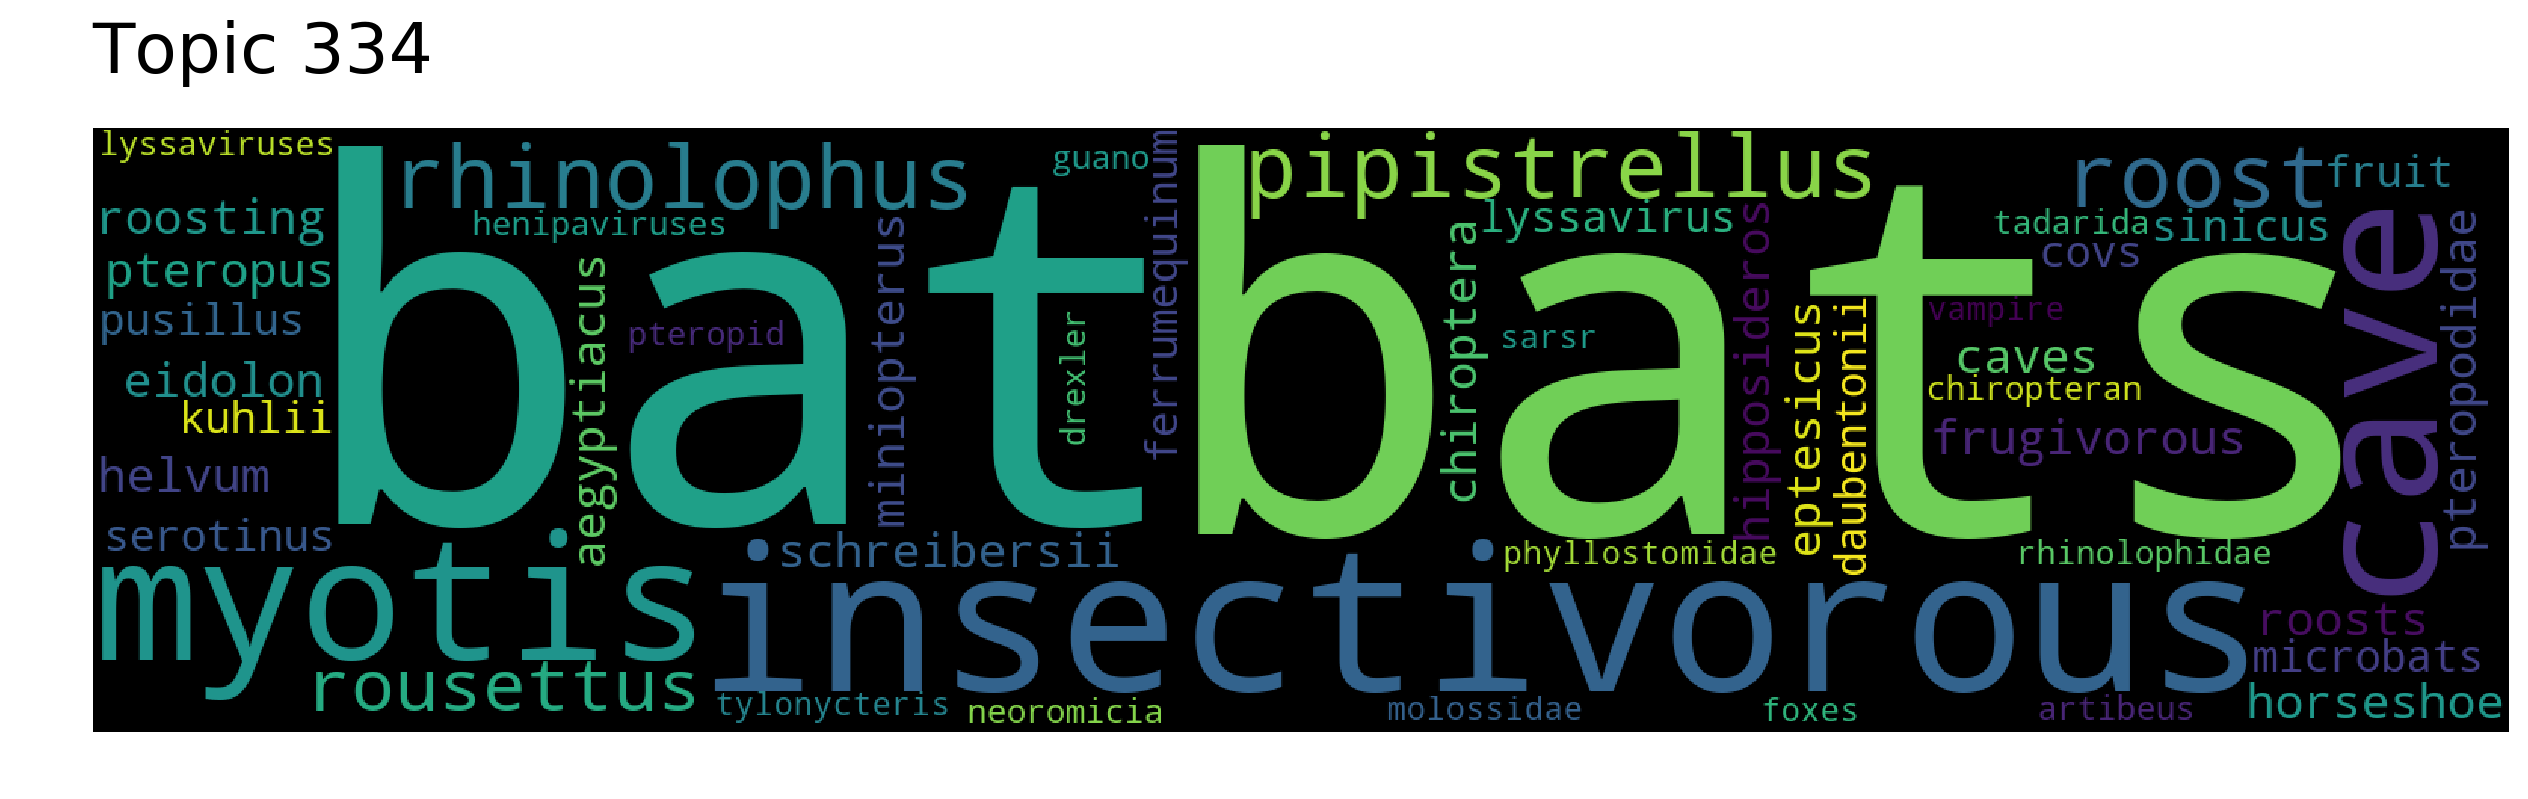

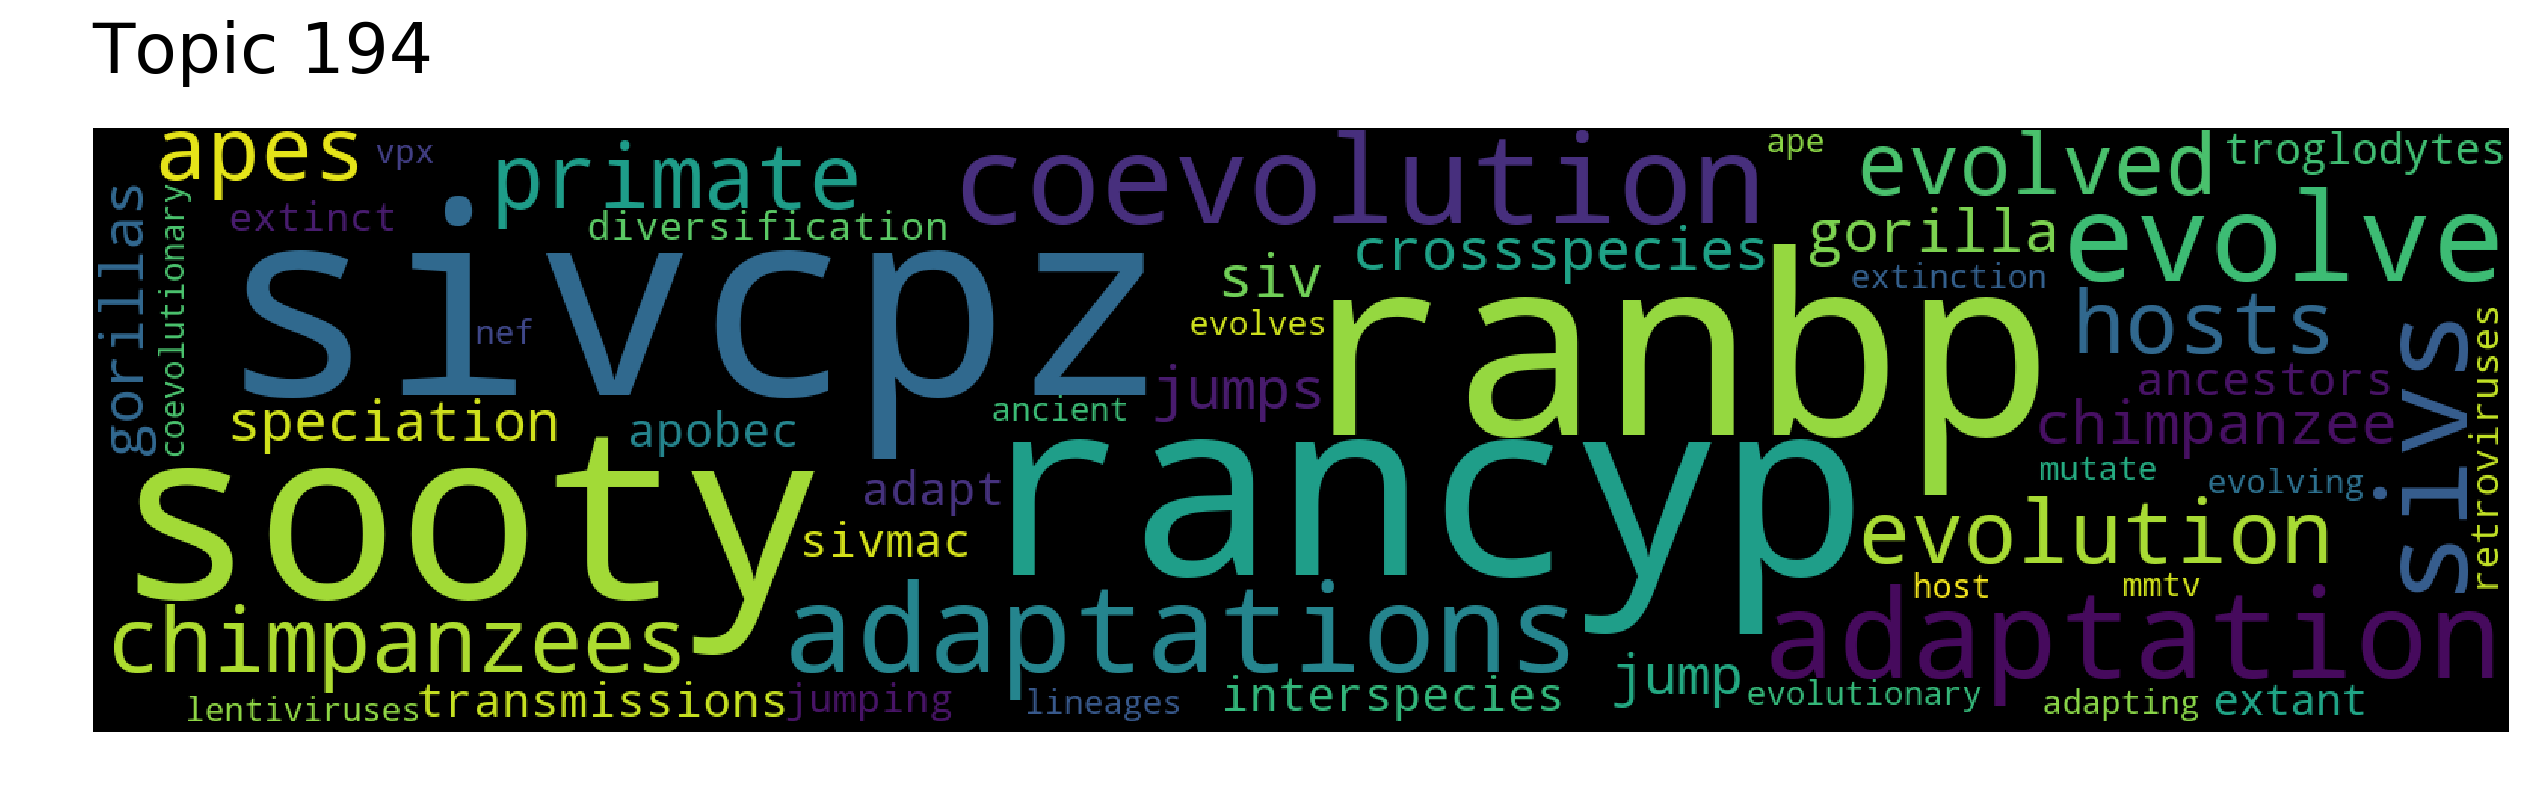

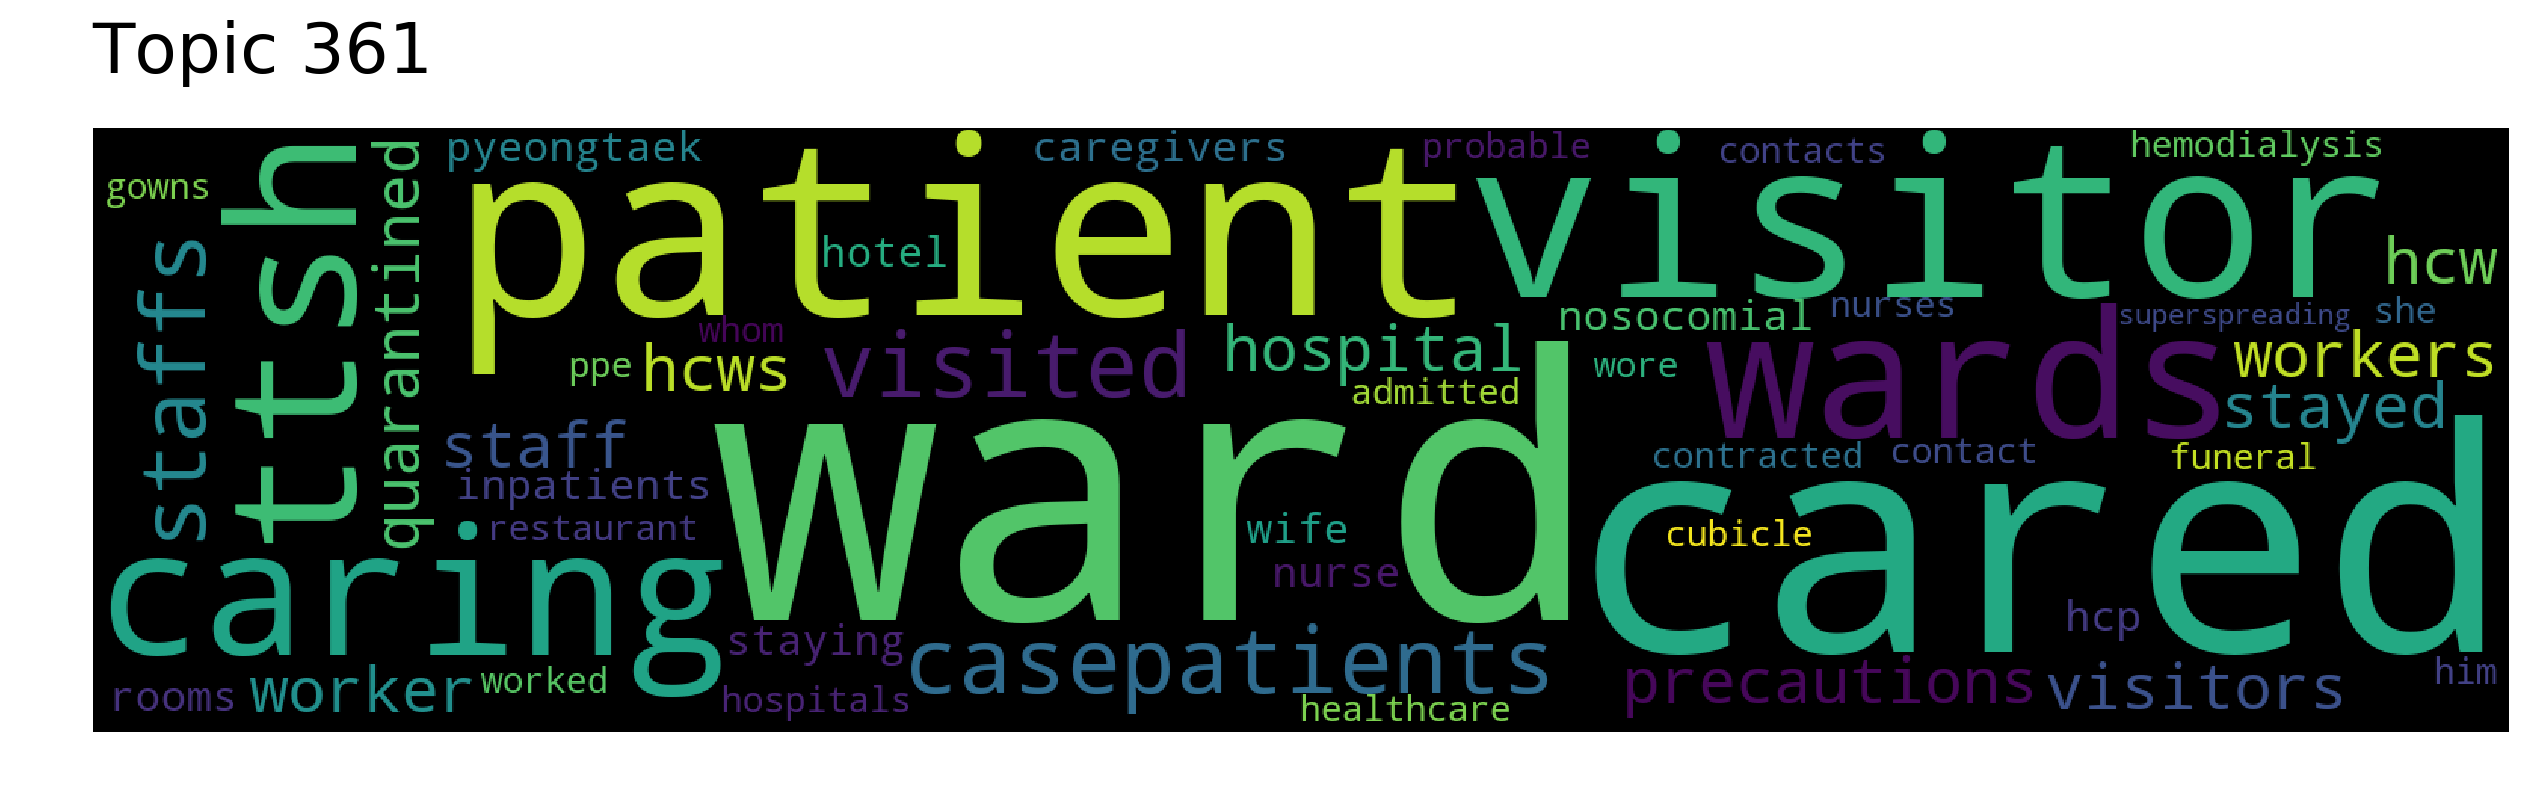

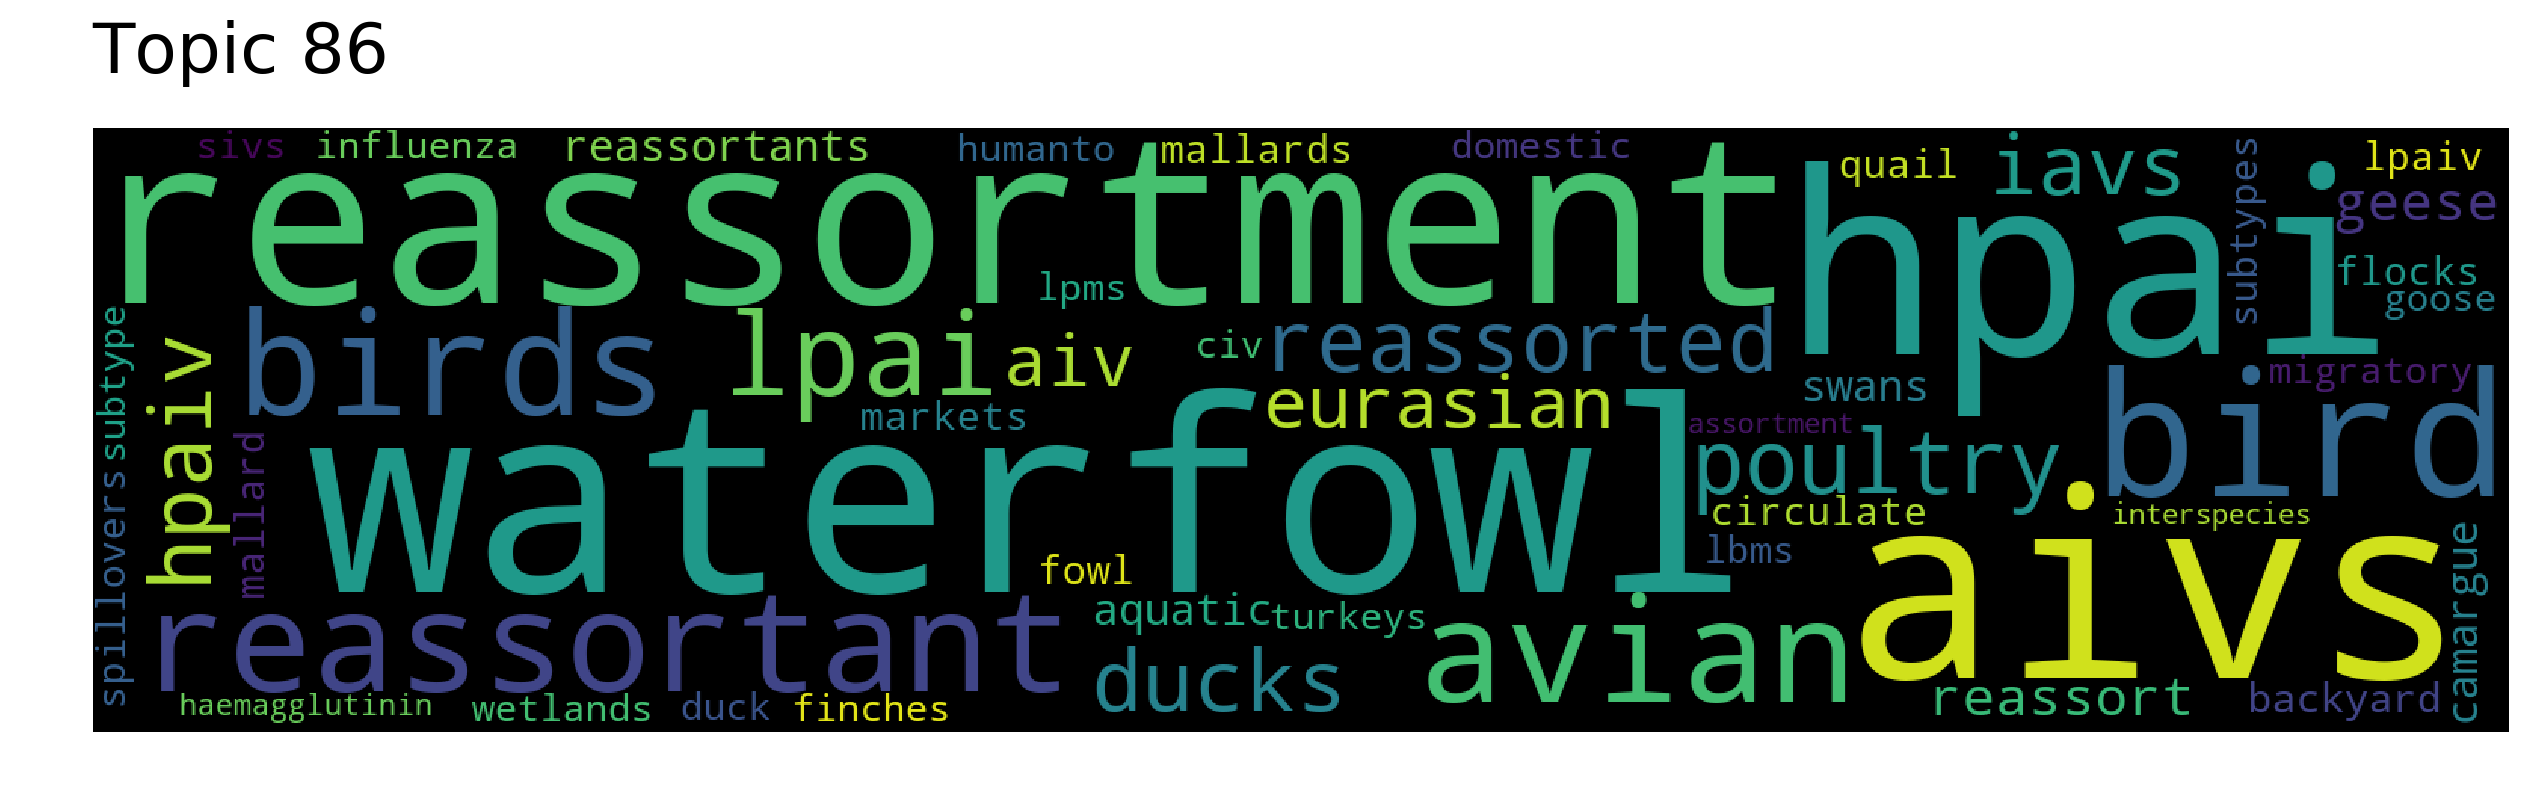

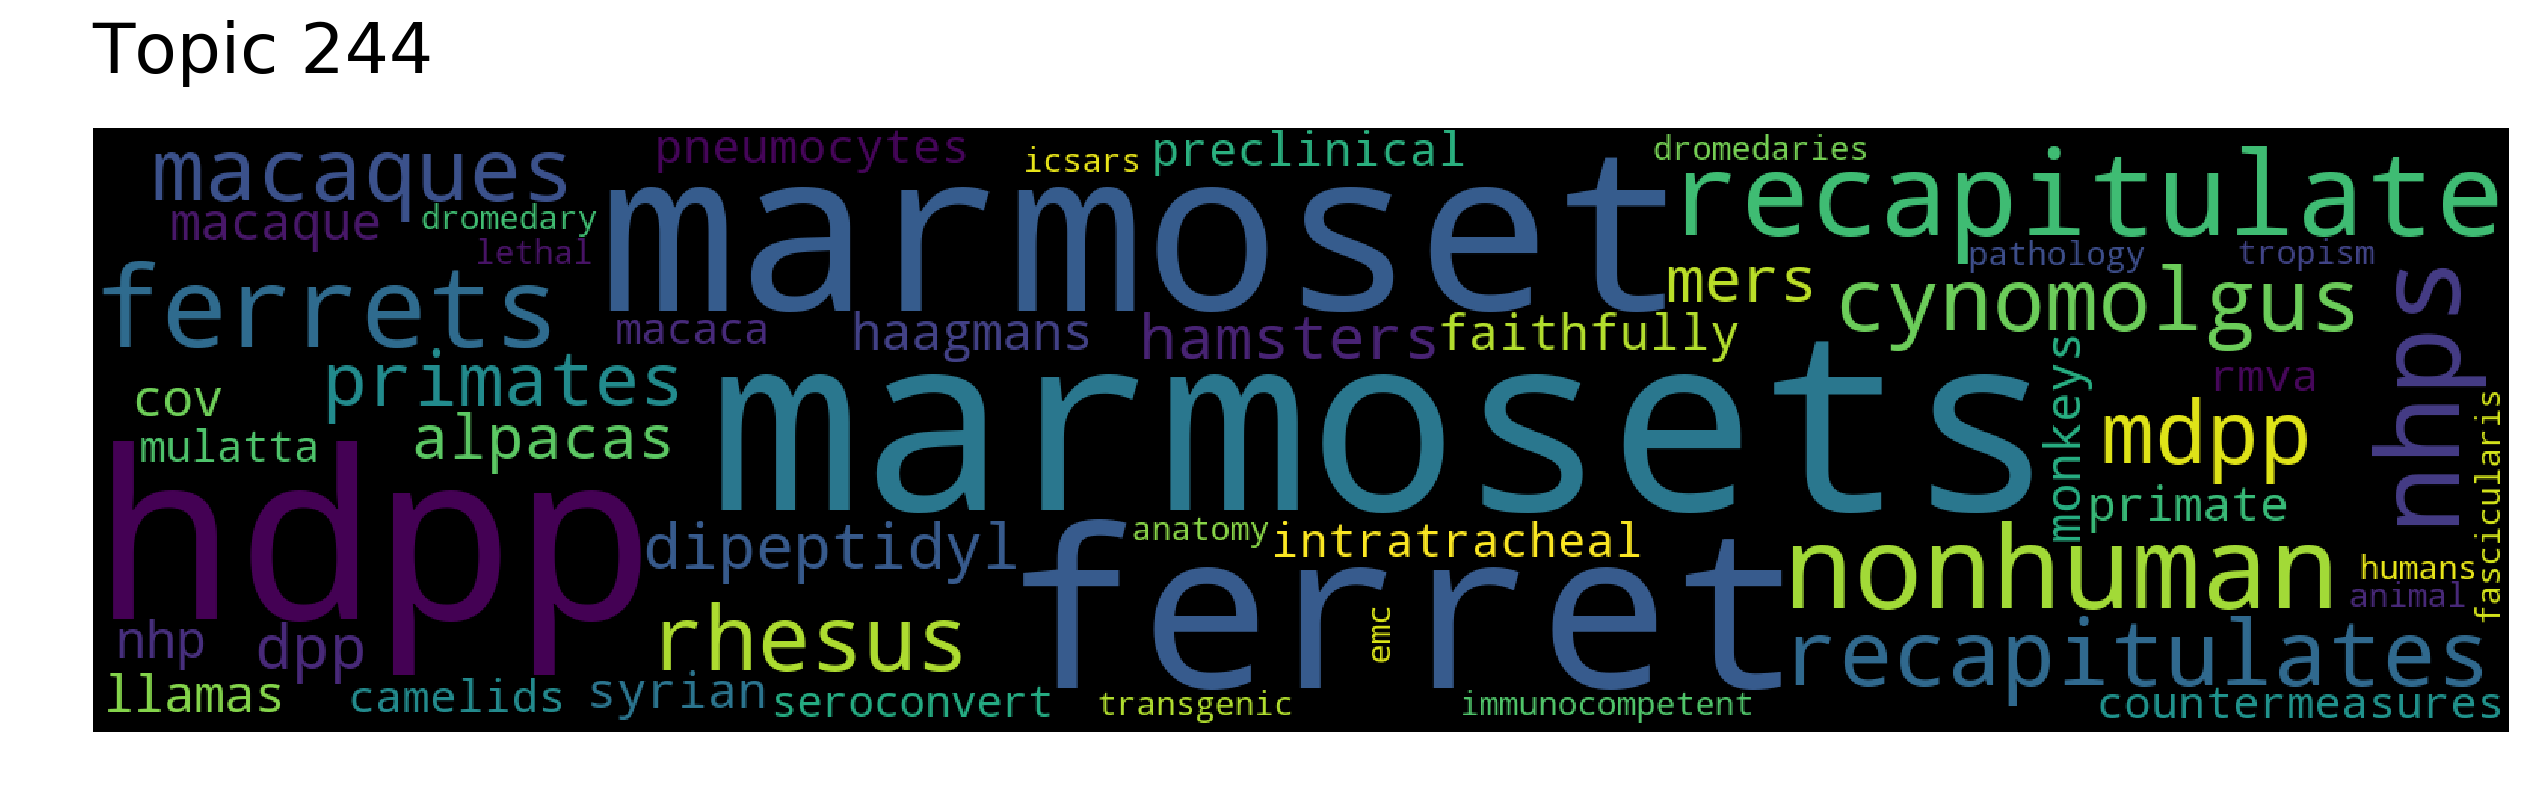

In [9]:
keywords_select_st = widgets.Label('Enter keywords seperated by space: ')
display(keywords_select_st)

keywords_input_st = widgets.Text()
display(keywords_input_st)

keywords_neg_select_st = widgets.Label('Enter negative keywords seperated by space: ')
display(keywords_neg_select_st)

keywords_neg_input_st = widgets.Text()
display(keywords_neg_input_st)

doc_num_select_st = widgets.Label('Choose number of topics: ')
display(doc_num_select_st)

doc_num_input_st = widgets.Text(value='5')
display(doc_num_input_st)

def display_similar_topics(*args):
    
    clear_output()
    display(keywords_select_st)
    display(keywords_input_st)
    display(keywords_neg_select_st)
    display(keywords_neg_input_st)
    display(doc_num_select_st)
    display(doc_num_input_st)
    display(keyword_btn_st)
    
    try:
        topic_words, word_scores, topic_scores, topic_nums = top2vec.search_topics(keywords=keywords_input_st.value.split(),num_topics=int(doc_num_input_st.value), keywords_neg=keywords_neg_input_st.value.split())
        for topic in topic_nums:
            top2vec.generate_topic_wordcloud(topic, background_color="black")
        
    except Exception as e:
        print(e)
        
keyword_btn_st = widgets.Button(description="show topics")
display(keyword_btn_st)
keyword_btn_st.on_click(display_similar_topics)

## 2. Search Papers by Topic

Search by topic 344, which appears to be about **infectiousness**.

In [10]:
topic_num_select = widgets.Label('Select topic number: ')
display(topic_num_select)

topic_input = widgets.Text()
display(topic_input)

doc_num_select = widgets.Label('Choose number of documents: ')
display(doc_num_select)

doc_num_input = widgets.Text(value='10')
display(doc_num_input)

def display_topics(*args):
    
    clear_output()
    display(topic_num_select)
    display(topic_input)
    display(doc_num_select)
    display(doc_num_input)
    display(topic_btn)

    documents, document_scores, document_nums = top2vec.search_documents_by_topic(topic_num=int(topic_input.value), num_docs=int(doc_num_input.value))
    
    result_df = papers_df.loc[document_nums]
    result_df["document_scores"] = document_scores
    
    for index,row in result_df.iterrows():
        print(f"Document: {index}, Score: {row.document_scores}")
        print(f"Section: {row.section}")
        print(f"Title: {row.title}")
        print("-----------")
        print(row.text)
        print("-----------")
        print()

topic_btn = widgets.Button(description="show documents")
display(topic_btn)
topic_btn.on_click(display_topics)

Label(value='Select topic number: ')

Text(value='344')

Label(value='Choose number of documents: ')

Text(value='2')

Button(description='show documents', style=ButtonStyle())

Document: 47398, Score: 0.5814
Section: The underlying model and some key epidemiological quantities
Title: Estimation in emerging epidemics: biases and remedies
-----------
We start by presenting the basic underlying epidemic model. We assume that individuals are at first susceptible and later may become infected, and that infected individuals may then infect other individuals. The infection ends with death or recovery. The population is assumed to be a homogeneously mixing community of homogeneous individuals. Since we model the initial phase of the outbreak, the depletion of susceptibles is considered as negligible. Also, we assume that individuals do not change their behaviour over the considered time period as a consequence of the ongoing outbreak, nor are there yet any control measures put in place by health authorities or similar. Finally, we assume that there are no seasonal changes in transmission. Predictions are made assuming that the disease spreading mechanism continues un

## 3. Search Papers by Keywords

Search for documents that are about **coronovirus** **models**.

In [11]:
keywords_select_kw = widgets.Label('Enter keywords seperated by space: ')
display(keywords_select_kw)

keywords_input_kw = widgets.Text()
display(keywords_input_kw)

keywords_neg_select_kw = widgets.Label('Enter negative keywords seperated by space: ')
display(keywords_neg_select_kw)

keywords_neg_input_kw = widgets.Text()
display(keywords_neg_input_kw)

doc_num_select_kw = widgets.Label('Choose number of documents: ')
display(doc_num_select_kw)

doc_num_input_kw = widgets.Text(value='10')
display(doc_num_input_kw)

def display_keywords(*args):
    
    clear_output()
    display(keywords_select_kw)
    display(keywords_input_kw)
    display(keywords_neg_select_kw)
    display(keywords_neg_input_kw)
    display(doc_num_select_kw)
    display(doc_num_input_kw)
    display(keyword_btn_kw)
    
    try:
        documents, document_scores, document_nums = top2vec.search_documents_by_keyword(keywords=keywords_input_kw.value.split(), num_docs=int(doc_num_input_kw.value), keywords_neg=keywords_neg_input_kw.value.split())
        result_df = papers_df.loc[document_nums]
        result_df["document_scores"] = document_scores

        for index,row in result_df.iterrows():
            print(f"Document: {index}, Score: {row.document_scores}")
            print(f"Section: {row.section}")
            print(f"Title: {row.title}")
            print("-----------")
            print(row.text)
            print("-----------")
            print()
           
    except Exception as e:
        print(e)
        

keyword_btn_kw = widgets.Button(description="show documents")
display(keyword_btn_kw)
keyword_btn_kw.on_click(display_keywords)

Label(value='Enter keywords seperated by space: ')

Text(value='covid model ')

Label(value='Enter negative keywords seperated by space: ')

Text(value='')

Label(value='Choose number of documents: ')

Text(value='2')

Button(description='show documents', style=ButtonStyle())

Document: 70634, Score: 0.4555
Section: Discussion
Title: An updated estimation of the risk of transmission of the novel coronavirus (2019-nCov)-NC-ND license (http://creativecommons.org/licenses/by-nc-nd/4.0/)
-----------
In our previous article (Tang et al., 2020) , we had estimated a reproduction number of 6.47 (95% CI 5.71e7.23), which represents a higher value than those so far computed. For instance, the WHO has estimated a reproduction number of 1.4e2.5, Li and colleagues have computed a slightly higher value of 2.2 (95% CI 1.4 to 3.9), while in several other mathematical models which have been so far devised and released as pre-prints or undergone peer-review and published, the reproduction number varies from 1.3 to 4.7. Within the existing literature, two studies estimated under-estimation of coronavirus cases: the investigations by Zhao and collaborators (Zhao et al., 2020) and by Read et al. (Read, Bridgen, Cummings, Ho, & Jewell, 2020) . Specifically, Zhao and coworkers (Zh

## 4. Find Similar Words

Find similar words to **chloroquine**.

In [12]:
keywords_select_sw = widgets.Label('Enter keywords seperated by space: ')
display(keywords_select_sw)

keywords_input_sw = widgets.Text()
display(keywords_input_sw)

keywords_neg_select_sw = widgets.Label('Enter negative keywords seperated by space: ')
display(keywords_neg_select_sw)

keywords_neg_input_sw = widgets.Text()
display(keywords_neg_input_sw)


doc_num_select_sw = widgets.Label('Choose number of words: ')
display(doc_num_select_sw)

doc_num_input_sw = widgets.Text(value='20')
display(doc_num_input_sw)

def display_similar_words(*args):
    
    clear_output()
    display(keywords_select_sw)
    display(keywords_input_sw)
    display(keywords_neg_select_sw)
    display(keywords_neg_input_sw)
    display(doc_num_select_sw)
    display(doc_num_input_sw)
    display(sim_word_btn_sw)
    
    try:            
        words, word_scores = top2vec.similar_words(keywords=keywords_input_sw.value.split(), keywords_neg=keywords_neg_input_sw.value.split(), num_words=int(doc_num_input_sw.value))
        for word, score in zip(words, word_scores):
            print(f"{word} {score}")
   
    except Exception as e:
        print(e)
        
sim_word_btn_sw = widgets.Button(description="show similar words")
display(sim_word_btn_sw)
sim_word_btn_sw.on_click(display_similar_words)

Label(value='Enter keywords seperated by space: ')

Text(value='chloroquine')

Label(value='Enter negative keywords seperated by space: ')

Text(value='')

Label(value='Choose number of words: ')

Text(value='20')

Button(description='show similar words', style=ButtonStyle())

chloroquine 1.0
lysosomotropic 0.6217
cq 0.5985
amodiaquine 0.5371
antimalarial 0.5278
bafilomycin 0.5164
acidification 0.4901
nitazoxanide 0.4712
aq 0.4647
favipiravir 0.4537
bafa 0.4442
arbidol 0.4416
drugs 0.422
chlorpromazine 0.4196
ribavirin 0.4194
toremifene 0.4129
analogs 0.4082
abma 0.4012
toxicity 0.3985
lysosome 0.394
